<a href="https://colab.research.google.com/github/ritikverma2000/Akshi/blob/ritik-transfer-learning/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle"

In [16]:
pwd

'/content/gdrive/My Drive/cbir'

In [18]:
#changing the working directory
%cd /content/gdrive/MyDrive/kaggle

/content/gdrive/MyDrive/kaggle


In [19]:
pwd


'/content/gdrive/My Drive/kaggle'

In [20]:
pwd

'/content/gdrive/My Drive/kaggle'

In [21]:
!kaggle datasets download -d gauravsharma99/fer13-cleaned-dataset

 60% 17.0M/28.2M [00:00<00:00, 30.9MB/s]
100% 28.2M/28.2M [00:00<00:00, 44.6MB/s]


In [22]:
!ls

fer13-cleaned-dataset.zip  kaggle.json


In [23]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Neutral/Training_59186253.jpg  
  inflating: Neutral/Training_59196451.jpg  
  inflating: Neutral/Training_59207899.jpg  
  inflating: Neutral/Training_59231702.jpg  
  inflating: Neutral/Training_59239314.jpg  
  inflating: Neutral/Training_59257029.jpg  
  inflating: Neutral/Training_59262777.jpg  
  inflating: Neutral/Training_5928809.jpg  
  inflating: Neutral/Training_59297234.jpg  
  inflating: Neutral/Training_59301844.jpg  
  inflating: Neutral/Training_59316619.jpg  
  inflating: Neutral/Training_59318324.jpg  
  inflating: Neutral/Training_59349555.jpg  
  inflating: Neutral/Training_5937470.jpg  
  inflating: Neutral/Training_59384298.jpg  
  inflating: Neutral/Training_59428060.jpg  
  inflating: Neutral/Training_59432107.jpg  
  inflating: Neutral/Training_59444533.jpg  
  inflating: Neutral/Training_5945842.jpg  
  inflating: Neutral/Training_59460112.jpg  
  inflating: Neutral/Training_5946814.jpg  
  inflat

In [24]:
INPUT_PATH = "/content/gdrive/MyDrive/kaggle/FER13 Cleaned Dataset/"



In [30]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    
    for f in os.listdir(INPUT_PATH +"/"+ dir_ ):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

Angry has 2832 number of images
Happy has 6834 number of images
Neutral has 4295 number of images
disgust has 380 number of images
fear has 2535 number of images

total images are 16876


In [31]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [34]:
!pip install scikit-plot

In [67]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [68]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH +"/"+ dir_ ):
            img_arr[i] = cv2.imread(INPUT_PATH +"/"+ dir_ +"/"+ f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Angry images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all fear images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [69]:
label_to_text

{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'fear'}

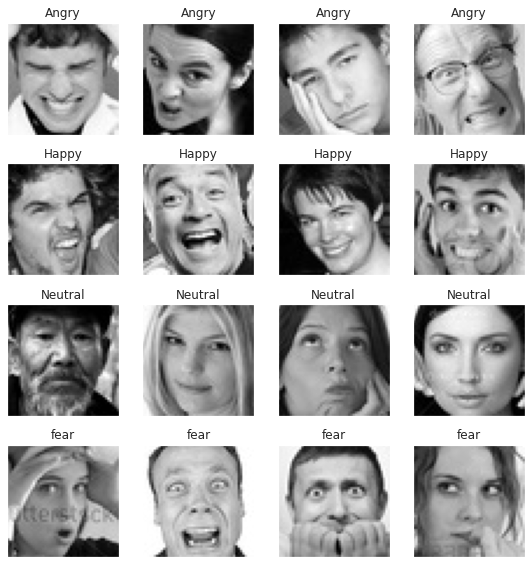

In [70]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [71]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16496, 4)

In [72]:
img_arr = img_arr / 255.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [74]:
del img_arr
del img_label

In [75]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [76]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

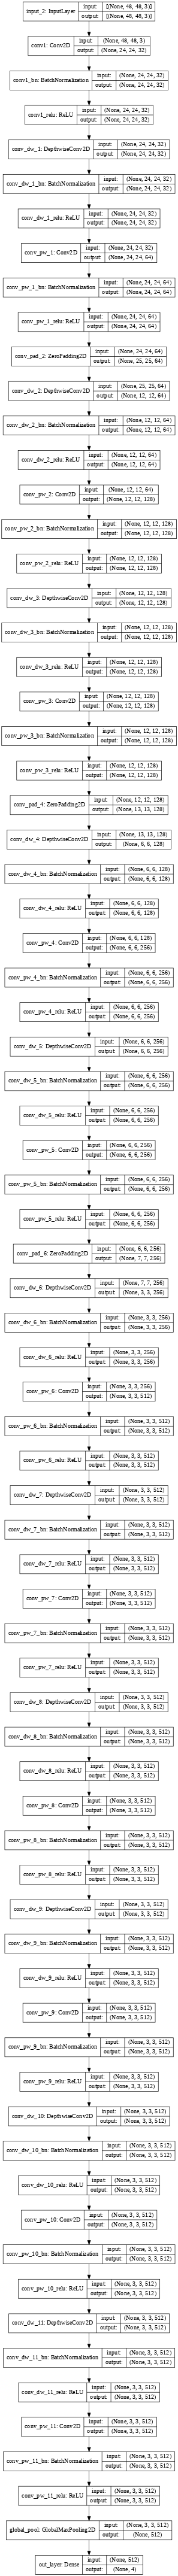

In [77]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [78]:
for layer in model.layers[:15]:
    layer.trainable = False

In [79]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [80]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [81]:
batch_size = 35
epochs = 35

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
424/424 [==============================] - 25s 53ms/step - loss: 1.2646 - accuracy: 0.5061 - val_loss: 1.2268 - val_accuracy: 0.6285
Epoch 2/35
424/424 [==============================] - 21s 50ms/step - loss: 0.9811 - accuracy: 0.6043 - val_loss: 1.0015 - val_accuracy: 0.6115
Epoch 3/35
424/424 [==============================] - 20s 48ms/step - loss: 0.9038 - accuracy: 0.6445 - val_loss: 1.0196 - val_accuracy: 0.6315
Epoch 4/35
424/424 [==============================] - 21s 49ms/step - loss: 0.8581 - accuracy: 0.6526 - val_loss: 0.9464 - val_accuracy: 0.6030
Epoch 5/35
424/424 [==============================] - 21s 48ms/step - loss: 0.8336 - accuracy: 0.6691 - val_loss: 0.8167 - val_accuracy: 0.6824
Epoch 6/35
424/424 [==============================] - 21s 49ms/step - loss: 0.8061 - accuracy: 0.6809 - val_loss: 0.8915 - val_accuracy: 0.6667
Epoch 7/35
424/424 [==============================] - 21s 49ms/step - loss: 0.7873 - accuracy: 0.6916 - val_loss: 1.0248 - val_accuracy:

In [82]:
model_yaml = model.to_json()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

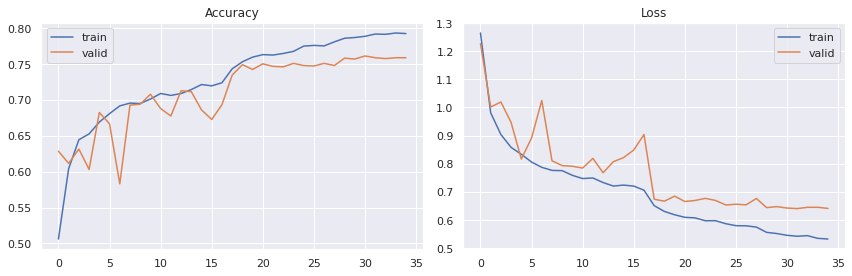

In [83]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [84]:
label_to_text

{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'fear'}

In [85]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Angry': 0, 'Happy': 1, 'Neutral': 2, 'fear': 3}

test accuracy: 75.8788 %


              precision    recall  f1-score   support

           0       0.66      0.62      0.64       283
           1       0.90      0.87      0.88       684
           2       0.66      0.79      0.72       430
           3       0.69      0.55      0.61       253

    accuracy                           0.76      1650
   macro avg       0.73      0.71      0.71      1650
weighted avg       0.76      0.76      0.76      1650



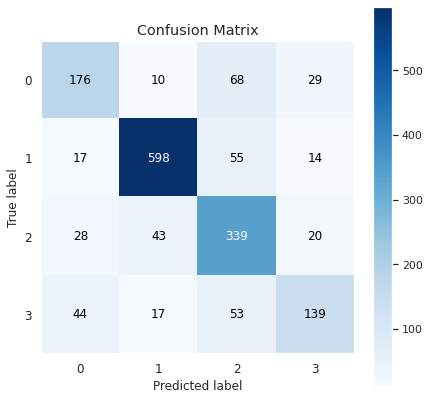

In [86]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

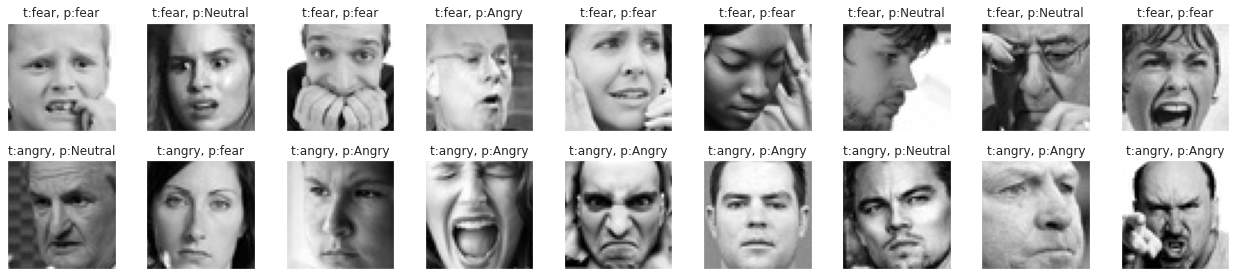

In [87]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()